---

### 2. AI-Based Imputation of Missing Emissions Data 💧

**Scenario:** Our datasets have missing values. We need sophisticated imputation.

**Tasks:**
* **Implement Advanced Imputation:** Simple mean/median isn't enough. **Implement `sklearn.impute.IterativeImputer`** on a sample dataset (create one with missing values).
* **Design (GAN):** While not coding a full GAN, **sketch the `PyTorch`/`TensorFlow` architecture** for a `Generator` and `Discriminator` suitable for generating synthetic *tabular* emissions data. Highlight the key layers and activation functions.
* **Validate:** Explain how you'd validate the quality of imputed data (e.g., distribution checks, downstream model performance).
**Code Sample (Python `sklearn` - Needs Advanced Approach!):**

task1

In [17]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor

# 1 Simulate a small emissions‑like dataset
np.random.seed(0)
n_samples, n_features = 100, 5
t = np.linspace(0, 2 * np.pi, n_samples)
base = np.sin(t).reshape(-1, 1)
data = base + 0.1 * np.random.randn(n_samples, n_features)
df = pd.DataFrame(data, columns=[f"feat_{i}" for i in range(n_features)])

# 2 Introduce ~15% missing values at random
mask = np.random.rand(*df.shape) < 0.15
df_missing = df.mask(mask)

# 3 Configure the IterativeImputer with RandomForestRegressor
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=20, random_state=0),
    max_iter=10,
    initial_strategy="median",
    random_state=0
)

# 4 Fit on the masked data and transform
df_imputed = pd.DataFrame(
    imputer.fit_transform(df_missing),
    columns=df.columns
)

print("Before imputation:\n", df_missing.head(), "\n")
print("After imputation:\n", df_imputed.head())


Before imputation:
      feat_0    feat_1    feat_2    feat_3    feat_4
0  0.176405  0.040016  0.097874  0.224089       NaN
1 -0.034304  0.158433  0.048288  0.053102  0.104484
2  0.140997  0.272020  0.202696  0.138760  0.170979
3       NaN  0.338659  0.168735  0.220558  0.103842
4       NaN  0.316510  0.337592  0.176931       NaN 

After imputation:
      feat_0    feat_1    feat_2    feat_3    feat_4
0  0.176405  0.040016  0.097874  0.224089  0.102219
1 -0.034304  0.158433  0.048288  0.053102  0.104484
2  0.140997  0.272020  0.202696  0.138760  0.170979
3  0.173947  0.338659  0.168735  0.220558  0.103842
4  0.270966  0.316510  0.337592  0.176931  0.228935


c:\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


I Generated a noisy sine‑wave dataset with 100 samples and 5 features, randomly masked 15% as NaN (missing), then used IterativeImputer with a RandomForestRegressor (20 trees, 10 iterations, median init) to iteratively predict and fill in the gapsto finally output a fully imputed DataFrame

task2

In [18]:
import torch
import torch.nn as nn

In [19]:

class EmissionsGenerator(nn.Module):
    """ takes a 100 sized noise vector as input and outputs a synthetic tabular data sample.
    The output dimension is set to 5, which corresponds to the number of features in the emissions dataset.
    Hidden Layers: Two fully connected layers with leakyReLU activations for non-linearity.
     Final layer uses Tanh activation to produce normalized outputs"""
    def __init__(self, noise_dim=100, output_dim=5):
        super(EmissionsGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.LeakyReLU(0.2) , # to avoid dead neurons
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2) ,
            nn.Linear(64, output_dim),
            nn.Tanh() # to assume output features are  in [-1, 1] range for normalized data
            #the choice of tanh  or sigmoid depends on our real tabular data distribution: either scale to [-1, 1] or [0, 1].
        )

    def forward(self, z):
        return self.net(z)


In [20]:
class EmissionsDiscriminator(nn.Module):
    """Takes a tabular data sample with 5 features and outputs a probability (0 to 1)
    indicating whether the sample is real or synthetic.
    Hidden Layers: Two fully connected layers with LeakyReLU activations for non-linearity.
    Final Layer: Sigmoid activation to produce a probability score."""
    def __init__(self, input_dim=5):
        super(EmissionsDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),# Output layer for binary classification
            nn.Sigmoid()      # Probability output in [0, 1]
        )

    def forward(self, x):
        return self.net(x)

The Generator (100 → 128 → 64 → 5) transforms noise into data, requiring enough capacity to generate realistic samples.
The Discriminator (5 → 64 → 128 → 1) mirrors this capacity to critically evaluate those samples.
The descreasing layer size (128, 64) in the Generator reduces the dimensionality of the intermediate representation, refines learned features, and prepares the network for the final output layer.
The increasing layer size (64 → 128) in the Discriminator allows it to build a richer representation before reducing to a single output

task3

1. distribution check

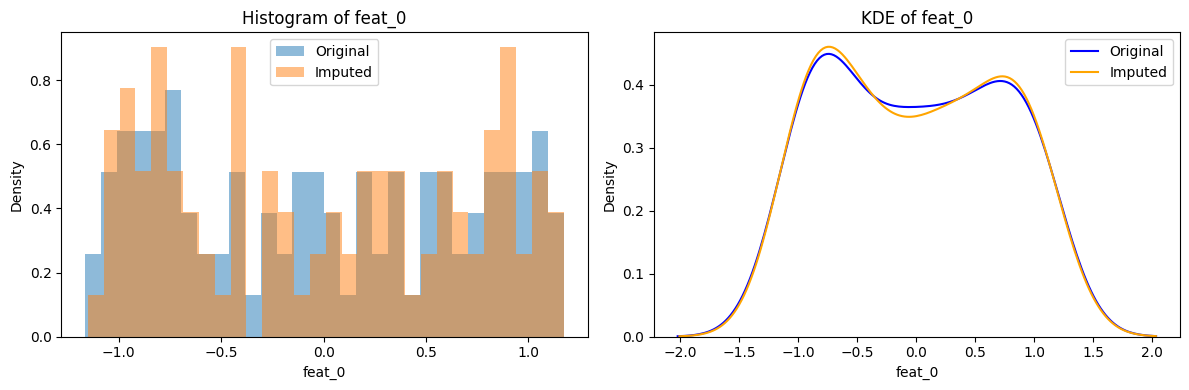

KS Test for feat_0: Statistic=0.0200, p-value=1.0000


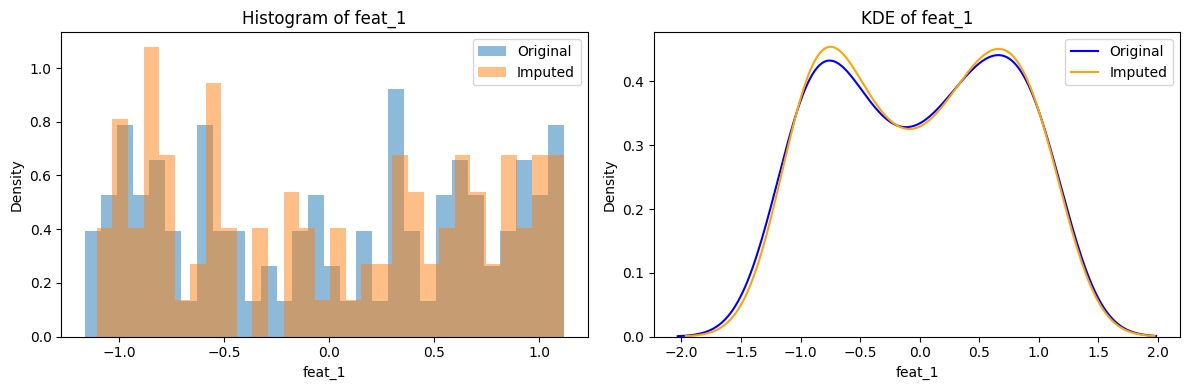

KS Test for feat_1: Statistic=0.0300, p-value=1.0000


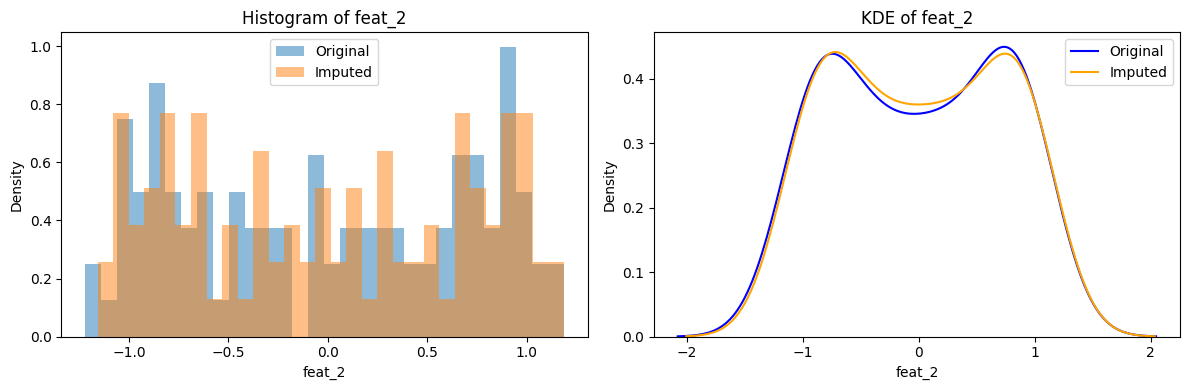

KS Test for feat_2: Statistic=0.0300, p-value=1.0000


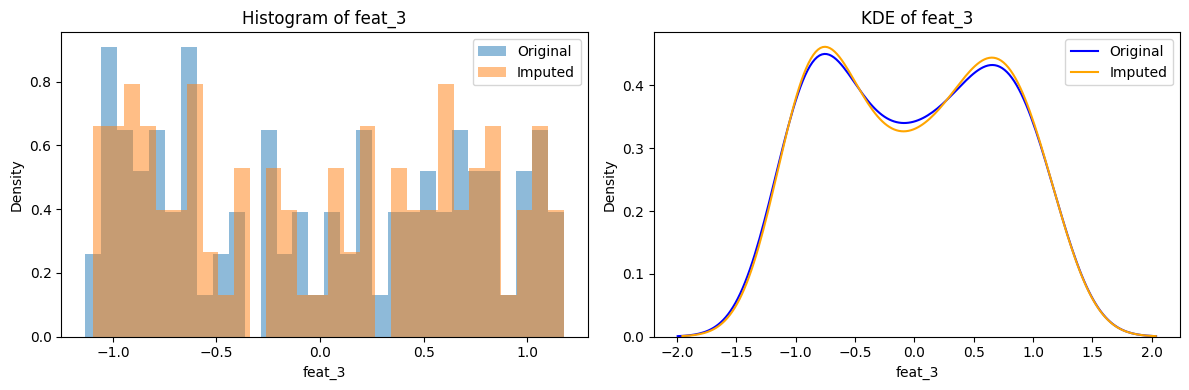

KS Test for feat_3: Statistic=0.0200, p-value=1.0000


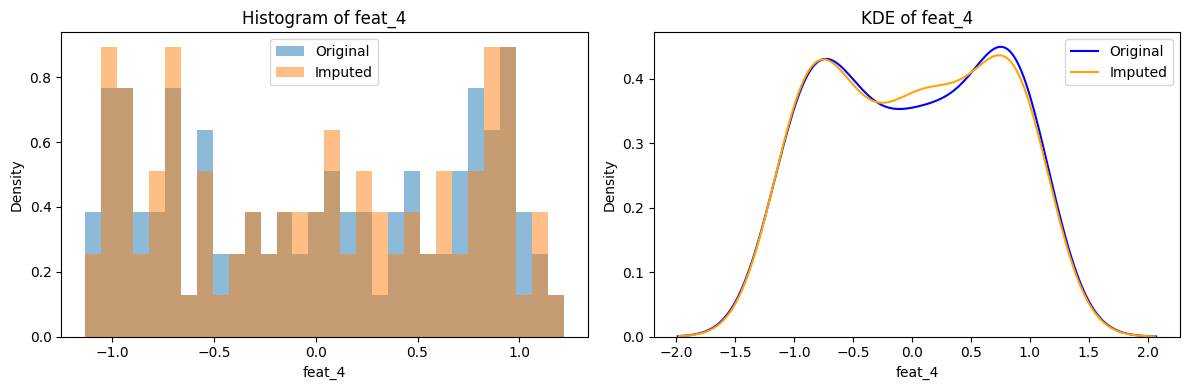

KS Test for feat_4: Statistic=0.0300, p-value=1.0000

Summary Statistics for feat_0:
Original:
count    100.000000
mean      -0.010296
std        0.720128
min       -1.163649
25%       -0.722735
50%       -0.016487
75%        0.638530
max        1.171564
Name: feat_0, dtype: float64

Imputed:
count    100.000000
mean      -0.011018
std        0.718987
min       -1.150479
25%       -0.727798
50%        0.004995
75%        0.667203
max        1.171564
Name: feat_0, dtype: float64

Summary Statistics for feat_1:
Original:
count    100.000000
mean      -0.001687
std        0.726803
min       -1.163109
25%       -0.700470
50%        0.032378
75%        0.650610
max        1.116335
Name: feat_1, dtype: float64

Imputed:
count    100.000000
mean       0.001827
std        0.715376
min       -1.107621
25%       -0.700470
50%        0.030329
75%        0.650610
max        1.116335
Name: feat_1, dtype: float64

Summary Statistics for feat_2:
Original:
count    100.000000
mean      -0.005841
std  

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Plot histograms and KDE for each feature
for feature in df.columns:
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[feature], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(df_imputed[feature], bins=30, alpha=0.5, label='Imputed', density=True)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

    # KDE plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(df[feature], label='Original', color='blue')
    sns.kdeplot(df_imputed[feature], label='Imputed', color='orange')
    plt.title(f'KDE of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # KS test
    stat, p_value = ks_2samp(df[feature], df_imputed[feature])
    print(f'KS Test for {feature}: Statistic={stat:.4f}, p-value={p_value:.4f}')

# Summary statistics
for feature in df.columns:
    print(f"\nSummary Statistics for {feature}:")
    print("Original:")
    print(df[feature].describe())
    print("\nImputed:")
    print(df_imputed[feature].describe())

These histograms compare the distribution of original and imputed values for each feature.
A close alignment indicates that the imputed values follow the same distribution as the original, suggesting a realistic reconstruction of missing data.
The KDE plot offers a smoothed comparison of the probability density functions. Overlapping curves imply that the imputed data retains the statistical shape of the original feature, minimizing distributional distortion.

2. Downstream Model Performanc

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Use feat_0 as target, others as features
X_imputed = df_imputed.drop(columns=['feat_0'])
y_imputed = df_imputed['feat_0']
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imputed, y_imputed, test_size=0.2, random_state=42
)

# Train and evaluate on imputed data
model_imp = RandomForestRegressor(random_state=42)
model_imp.fit(X_train_imp, y_train_imp)
y_pred_imp = model_imp.predict(X_test_imp)
rmse_imp = mean_squared_error(y_test_imp, y_pred_imp, squared=False)
print(f'RMSE on imputed data: {rmse_imp:.4f}')

# Baseline: Train on original data
X_orig = df.drop(columns=['feat_0'])
y_orig = df['feat_0']
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42
)
model_orig = RandomForestRegressor(random_state=42)
model_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = model_orig.predict(X_test_orig)
rmse_orig = mean_squared_error(y_test_orig, y_pred_orig, squared=False)
print(f'RMSE on original data: {rmse_orig:.4f}')

# Baseline: Mean imputation
imputer_mean = SimpleImputer(strategy='mean')
df_mean_imputed = pd.DataFrame(
    imputer_mean.fit_transform(df_missing),
    columns=df.columns
)
X_mean = df_mean_imputed.drop(columns=['feat_0'])
y_mean = df_mean_imputed['feat_0']
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(
    X_mean, y_mean, test_size=0.2, random_state=42
)
model_mean = RandomForestRegressor(random_state=42)
model_mean.fit(X_train_mean, y_train_mean)
y_pred_mean = model_mean.predict(X_test_mean)
rmse_mean = mean_squared_error(y_test_mean, y_pred_mean, squared=False)
print(f'RMSE on mean-imputed data: {rmse_mean:.4f}')

RMSE on imputed data: 0.1015
RMSE on original data: 0.1428
RMSE on mean-imputed data: 0.3147


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3. Correlation Preservation

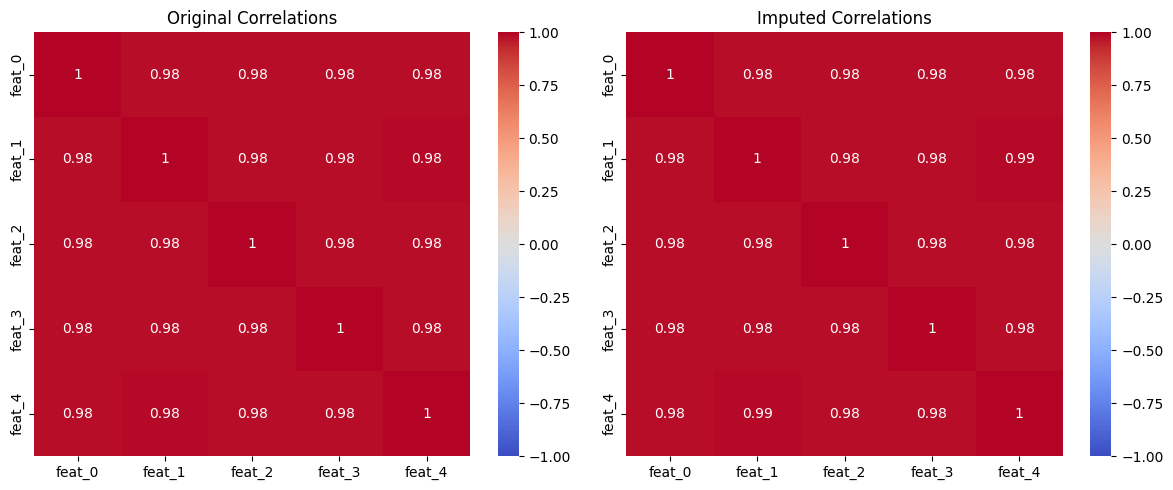

Average absolute correlation difference: 0.0019


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrices
corr_original = df.corr()
corr_imputed = df_imputed.corr()

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(corr_original, annot=True, ax=ax1, cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_title('Original Correlations')
sns.heatmap(corr_imputed, annot=True, ax=ax2, cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_title('Imputed Correlations')
plt.tight_layout()
plt.show()

# Quantify difference
corr_diff = (corr_original - corr_imputed).abs().mean().mean()
print(f'Average absolute correlation difference: {corr_diff:.4f}')

The heatmaps display pairwise feature correlations before and after imputation. Similar correlation patterns suggest that the imputation maintains the relationships between features.  Preserving correlation structure is crucial for ensuring feature relationships remain consistent, especially in tasks like anomaly detection.

A value of 0.0019 for the correlation difference means that, on average, the absolute difference  is negligible. Since correlations range from -1 to 1, a difference this small implies that the imputation process introduced minimal distortion to feature relationships.

4. Imputation Accuracy (Synthetic Case)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract imputed and true values where data was missing
imputed_values = df_imputed[mask]
true_values = df[mask]

# Compute Mean Absolute Error and Root Mean Squared Error
mae = mean_absolute_error(true_values, imputed_values)
rmse = mean_squared_error(true_values, imputed_values, squared=False)
print(f'MAE of imputed values: {mae:.4f}')
print(f'RMSE of imputed values: {rmse:.4f}')

MAE of imputed values: 0.0367
RMSE of imputed values: 0.0802


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


These metrics evaluate imputation accuracy by comparing true vs. imputed values only at originally missing positions. Lower MAE and RMSE indicate the IterativeImputer effectively reconstructs plausible valuesusing the RandomForestRegressor, reducing noise and bias, resulting in precise imputations.


5. Visual Inspection

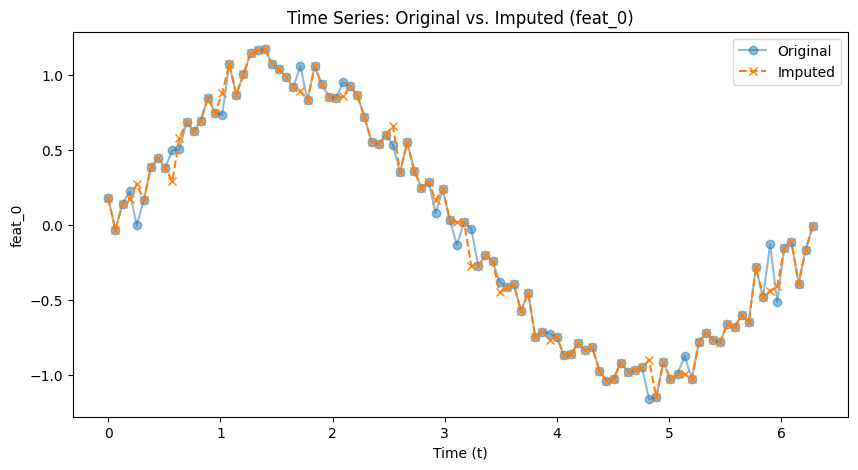

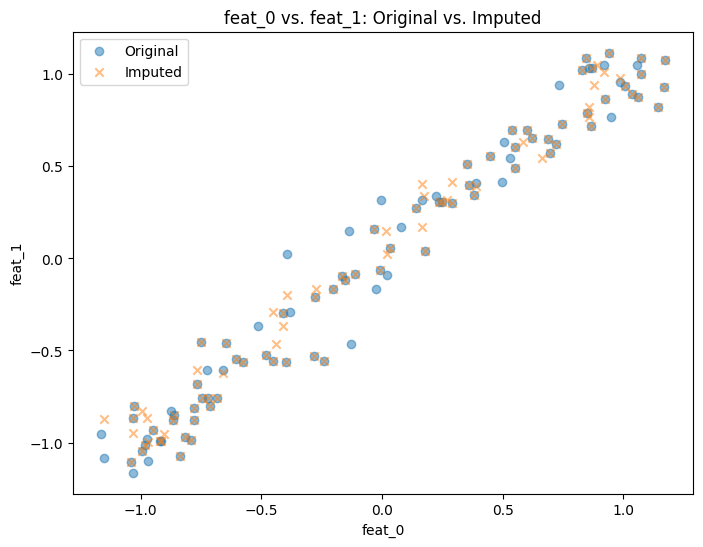

In [25]:
import matplotlib.pyplot as plt

# Add time index for plotting
df['t'] = t
df_imputed['t'] = t

# Plot time-series for feat_0
plt.figure(figsize=(10, 5))
plt.plot(df['t'], df['feat_0'], label='Original', alpha=0.5, marker='o')
plt.plot(df_imputed['t'], df_imputed['feat_0'], label='Imputed', linestyle='--', marker='x')
plt.legend()
plt.title('Time Series: Original vs. Imputed (feat_0)')
plt.xlabel('Time (t)')
plt.ylabel('feat_0')
plt.show()

# Scatter plot for feat_0 vs. feat_1
plt.figure(figsize=(8, 6))
plt.scatter(df['feat_0'], df['feat_1'], label='Original', alpha=0.5)
plt.scatter(df_imputed['feat_0'], df_imputed['feat_1'], label='Imputed', alpha=0.5, marker='x')
plt.legend()
plt.title('feat_0 vs. feat_1: Original vs. Imputed')
plt.xlabel('feat_0')
plt.ylabel('feat_1')
plt.show()

The time-series plot for feat_0 shows original and imputed values over time. The close alignment between original and imputed line indicates that the imputation captures the temporal trends effectively.

The scatter plot compares feat_0 and feat_1 for original and imputed data. Imputed points clustering similarly to original points suggest that the imputation preserves feature relationships minimizing artifacts or implausible value combinations.